In [1]:
import sys
import torch
import mlflow
import optuna
import numpy as np
import pandas as pd
from datetime import datetime
from darts import TimeSeries
import plotly.express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt
from darts.metrics import mae, mse, mape, rmse, smape
from darts.dataprocessing.transformers.scaler import Scaler
from pytorch_lightning.callbacks import EarlyStopping
from optuna.integration import PyTorchLightningPruningCallback
from darts.models import RNNModel, BlockRNNModel, TCNModel, TransformerModel, TCNModel, NBEATSModel

sys.path.append('../utils/')

from config import config

freq='2H3T14S'
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("OpenMarsHyperOpt")
pd.options.plotting.backend = "plotly"


In [2]:
def load_dataset(training_file, testing_file):
    dataframes = []
    for data_file in [training_file, testing_file]:
        parser = lambda data_string: datetime.strptime(data_string, '%Y-%m-%d %H:%M:%S')
        dataframe = pd.read_csv(data_file, parse_dates=['Time'],
                                date_parser=parser)
        print(f"Rows in {data_file}: {len(dataframe)}")
        dataframe.drop(['Ls', 'LT', 'CO2ice'], axis=1, inplace=True)
        dataframes.append(dataframe)

    return pd.concat(dataframes, axis=0)


def preprocess(dataframe):
        time = pd.date_range("1998-07-15 21:23:39", periods=len(dataframe), freq=freq)
        dataframe.index = time
        dataframe = dataframe.drop(['Time'], axis=1)
        return dataframe

def create_series(dataframe):
        series = TimeSeries.from_dataframe(dataframe, time_col=None, value_cols=None, fill_missing_dates=True, freq='7394S', fillna_value=None)
        return series.astype(np.float32)

def create_train_val_test_series(series):
        train, temp = series.split_after(0.7)
        val, test = temp.split_after(0.67)
        return train, val, test

In [3]:
dataframe = load_dataset('../data/data_files/insight_openmars_training_time.csv',
                         '../data/data_files/insight_openmars_test_time.csv')
dataframe = preprocess(dataframe)
train, val, test = create_train_val_test_series(create_series(dataframe))
# print(len(train), len(val), len(test))

/tmp/ipykernel_105728/3053129343.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataframe = pd.read_csv(data_file, parse_dates=['Time'],


Rows in ../data/data_files/insight_openmars_training_time.csv: 72196
Rows in ../data/data_files/insight_openmars_test_time.csv: 16364


/tmp/ipykernel_105728/3053129343.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataframe = pd.read_csv(data_file, parse_dates=['Time'],


<Axes: xlabel='time'>

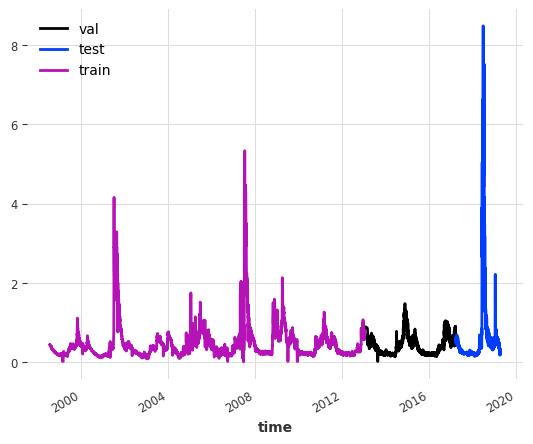

In [4]:
val['dust'].plot(label='val')
test['dust'].plot(label='test')
train['dust'].plot(label='train')


In [5]:
scaler = Scaler()  # default uses sklearn's MinMaxScaler
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
models = {}

In [6]:
def create_block_rnn_model(trial):

    # select input and output chunk lengths
    in_len = trial.suggest_categorical("input_chunk_length", [12, 24, 36, 48, 96])
    out_len =  in_len-1
    batch_size = trial.suggest_categorical('batch_size', [32, 96, 128, 256])

    # Other hyperparameters
    n_rnn_layers = trial.suggest_int("n_rnn_layers", 2, 5)
    hidden_dim =  trial.suggest_categorical("hidden_dim", [20, 30, 40, 60])
    dropout = trial.suggest_categorical("dropout", [0.05, 0.1, 0.15, 0.2, 0.25])
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    # reproducibility
    torch.manual_seed(42)

    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.0008, patience=2, verbose=False)
    callbacks = [pruner, early_stopper]

    pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 50,
    "accelerator": "auto",
    "callbacks": callbacks,
    }

    common_model_args = {
        "optimizer_kwargs": {'lr': lr},
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": config.lr_scheduler_kwargs,
        "likelihood": None,  # use a likelihood for probabilistic forecasts
        "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
        "force_reset": True,
        "random_state": 42,

    }
    # build the BlockRNNModel model
    model = BlockRNNModel(model = "LSTM",
                                input_chunk_length= in_len,
                                output_chunk_length = out_len,
                                n_rnn_layers = n_rnn_layers,
                                hidden_dim = hidden_dim,
                                batch_size = batch_size,
                                model_name="BlockRNNModel", 
                                dropout = dropout,
                                **common_model_args)
    return model

def create_rnn_model(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_categorical("input_chunk_length", [12, 24, 36, 48, 96])
    out_len =  in_len-1
    batch_size = trial.suggest_categorical('batch_size', [32, 96, 128, 256])
    # Other hyperparameters

    n_rnn_layers = trial.suggest_int("n_rnn_layers", 2, 5)
    hidden_dim =  trial.suggest_int("hidden_dim", 20, 40)
    dropout = trial.suggest_categorical("dropout", [0.05, 0.1, 0.15, 0.2, 0.25])
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    # reproducibility
    torch.manual_seed(42)


    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.0008, patience=2, verbose=False)
    callbacks = [pruner, early_stopper]

    # detect if a GPU is available
    if torch.cuda.is_available():
        num_workers = 8
    else:
        num_workers = 0

    pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 50,
    "accelerator": "auto",
    "callbacks": callbacks,
    }

    common_model_args = {
        "optimizer_kwargs": {'lr': lr},
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": config.lr_scheduler_kwargs,
        "likelihood": None,  # use a likelihood for probabilistic forecasts
        "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
        "force_reset": True,
        "batch_size": batch_size,
        "random_state": 42,

    }

    # build the BlockRNNModel model
    model = RNNModel(model = "LSTM",
                                input_chunk_length= in_len,
                                output_chunk_length = out_len,
                                n_rnn_layers = n_rnn_layers,
                                hidden_dim = hidden_dim,
                                model_name="RNNModel", 
                                dropout = dropout,
                                **common_model_args)
    return model

def create_tcn_model(trial):
    in_len = trial.suggest_categorical("input_chunk_length", [12, 24, 36, 48, 96])
    out_len =  in_len-1
    batch_size = trial.suggest_categorical('batch_size', [32, 96, 128, 256])
    # Other hyperparameters
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    num_filters = trial.suggest_int("num_filters", 2, 6)
    weight_norm = trial.suggest_categorical("weight_norm", [False, True])
    dilation_base = trial.suggest_int("dilation_base", 2, 4)
    dropout = trial.suggest_categorical("dropout", [0.05, 0.1, 0.15, 0.2, 0.25])
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    # reproducibility
    torch.manual_seed(42)


    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.0008, patience=2, verbose=False)
    callbacks = [pruner, early_stopper]



    pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 50,
    "accelerator": "auto",
    "callbacks": callbacks,
    }

    common_model_args = {
        "optimizer_kwargs": {'lr': lr},
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": config.lr_scheduler_kwargs,
        "likelihood": None,  # use a likelihood for probabilistic forecasts
        "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
        "force_reset": True,
        "batch_size": batch_size,
        "random_state": 42,

    }

    # build the TCN model
    model = TCNModel(
    input_chunk_length= in_len,
    output_chunk_length = out_len,
    dilation_base = dilation_base,
    weight_norm = weight_norm,
    kernel_size = kernel_size,
    num_filters = num_filters,
    model_name = 'TCNModel',
    dropout = dropout,
    **common_model_args
    )

    return model

def create_transformer_model(trial):
    in_len = trial.suggest_categorical("input_chunk_length", [12, 24, 36, 48, 96])
    out_len =  in_len-1
    batch_size = trial.suggest_categorical('batch_size', [32, 96, 128, 256])

    # Other hyperparameters

    d_model=trial.suggest_categorical('d_model', [8,12,16])
    if d_model == 8:
        nhead=4
    elif d_model == 12:
        nhead=6
    elif d_model == 16:
        nhead=8
    num_encoder_layers=trial.suggest_categorical('num_encoder_layers', [2,4])
    num_decoder_layers=trial.suggest_categorical('num_decoder_layers', [2,4])
    dim_feedforward=trial.suggest_categorical('dim_feedforward', [64, 128, 256])
    dropout = trial.suggest_categorical("dropout", [0.05, 0.1, 0.15, 0.2, 0.25])
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    # reproducibility
    torch.manual_seed(42)


    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.0008, patience=2, verbose=False)
    callbacks = [pruner, early_stopper]



    pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 50,
    "accelerator": "auto",
    "callbacks": callbacks,
    }

    common_model_args = {
        "optimizer_kwargs": {'lr': lr},
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": config.lr_scheduler_kwargs,
        "likelihood": None,  # use a likelihood for probabilistic forecasts
        "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
        "force_reset": True,
        "batch_size": batch_size,
        "random_state": 42,

    }

    # build the NBetas model
    model = TransformerModel(
    input_chunk_length=in_len,
    output_chunk_length=out_len,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    activation="relu",
    model_name = 'TransformerModel',
    **common_model_args,
)
    
    return model

In [7]:
VAL_LEN = 512

def objective_tcn(trial):
    # select input and output chunk lengths
    model = create_tcn_model(trial)
        # detect if a GPU is available
    if torch.cuda.is_available():
        num_workers = 8
    else:
        num_workers = 0

    series = create_series(dataframe)

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = val

    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    models[model.model_name] = TCNModel.load_from_checkpoint("TCNModel", best=True)

    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(series=train, n=VAL_LEN)
    smapes = rmse(val['dust'], preds['dust'], n_jobs=-1, verbose=True)
    # smape_val = np.mean(smapes)
    # smape_val = smapes

    return smapes if smapes != np.nan else float("inf")


def objective_block_rnn(trial):
    model = create_block_rnn_model(trial)
    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
        # detect if a GPU is available
    if torch.cuda.is_available():
        num_workers = 8
    else:
        num_workers = 0
    model_val_set = val
    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    model = BlockRNNModel.load_from_checkpoint("BlockRNNModel", best=True)

    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(series=train, n=VAL_LEN)
    smapes = rmse(val['dust'], preds['dust'], n_jobs=-1, verbose=True)
    smape_val = smapes

    return smape_val if smape_val != np.nan else float("inf")

def objective_rnn(trial):
    model = create_rnn_model(trial)
    if torch.cuda.is_available():
        num_workers = 8
    else:
        num_workers = 0

    # set which also contains the first input_chunk_length time steps
    model_val_set = val
    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    models[model.model_name] = RNNModel.load_from_checkpoint("RNNModel", best=True)

    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(series=train, n=VAL_LEN)
    smapes = rmse(val['dust'], preds['dust'], n_jobs=-1, verbose=True)
    smape_val = smapes

    return smape_val if smape_val != np.nan else float("inf")


def objective_nbeats(trial):
    # select input and output chunk lengths
    in_len = trial.suggest_categorical("input_chunk_length", [12, 24, 36, 48, 96])
    out_len =  in_len-1
    batch_size = trial.suggest_categorical('batch_size', [32, 96, 256])

    # Other hyperparameters

    num_blocks=trial.suggest_int('num_blocks', 2, 4)
    num_layers=trial.suggest_int('num_layers', 2, 5),
    layer_widths=trial.suggest_categorical('layer_widths', [256,512])
    dropout = trial.suggest_categorical("dropout", [0.05, 0.1, 0.15, 0.2, 0.25])
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    # reproducibility
    torch.manual_seed(42)


    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.0008, patience=2, verbose=False)
    callbacks = [pruner, early_stopper]

    # detect if a GPU is available
    if torch.cuda.is_available():
        num_workers = 8
    else:
        num_workers = 0

    pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 50,
    "accelerator": "auto",
    "callbacks": callbacks,
    }

    common_model_args = {
        "optimizer_kwargs": {'lr': lr},
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": config.lr_scheduler_kwargs,
        "likelihood": None,  # use a likelihood for probabilistic forecasts
        "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
        "force_reset": True,
        "batch_size": batch_size,
        "random_state": 42,

    }

    # build the NBetas model
    model = NBEATSModel(
        generic_architecture=False,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=layer_widths,
        loss_fn=torch.nn.MSELoss(),
        input_chunk_length= in_len,
        output_chunk_length = out_len,
        model_name = 'NBEATSModel',
        dropout=dropout,
        **common_model_args,

)
    

    series = create_series(dataframe)

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = val
    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    models[model.model_name] = NBEATSModel.load_from_checkpoint("NBEATSModel", best=True)

    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(series=train, n=VAL_LEN)
    smapes = rmse(val['dust'], preds['dust'], n_jobs=-1, verbose=True)
    smape_val = np.mean(smapes)

    return smape_val if smape_val != np.nan else float("inf")


def objective_transformer(trial):
    # select input and output chunk lengths
    model = create_transformer_model(trial)
    series = create_series(dataframe)

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = val
        # detect if a GPU is available
    if torch.cuda.is_available():
        num_workers = 8
    else:
        num_workers = 0
    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        num_loader_workers=num_workers,
    )

    # reload best model over course of training
    models[model.model_name] = TransformerModel.load_from_checkpoint("TransformerModel", best=True)

    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(series=train, n=VAL_LEN)
    smapes = rmse(val['dust'], preds['dust'], n_jobs=-1, verbose=True)
    smape_val = smapes

    return smape_val if smape_val != np.nan else float("inf")


In [8]:
def evaluate_model(model, test, forecast_horizon):
    result_accumulator = {}
    print(f'For model {model.model_name}')
    pred_series = model.historical_forecasts(series=test, 
                                        past_covariates=None,
                                        future_covariates=None,
                                        retrain=False,
                                        verbose=True, 
                                        forecast_horizon=forecast_horizon
                                        )
    test_dust = test['dust']
    pred_dust = pred_series['dust']
    result_accumulator[model.model_name] = {
        "mae": mae(test_dust, pred_dust),
        "mse": mse(test_dust, pred_dust),
        "mape": mape(test_dust, pred_dust),
        "rmse": rmse(test_dust, pred_dust)
    }
    return result_accumulator, pred_series

In [9]:
def train_model(model, val):
    print('model to train', model)
    model.fit(
        series=train,
            val_series=val,
            verbose=True,
            )
    model.save(f'../model_files/{model.model_name}.pt')
    return model


In [18]:
def logging(model, test):
    forecast_horizon = model.model_params['output_chunk_length']
    with mlflow.start_run(run_name=model.model_name):
    # Log the hyperparameters
        mlflow.log_params(model.model_params)

        # Log the loss metric
        eval_results, pred_series = evaluate_model(model, test, forecast_horizon)
        print(eval_results)
        for metric, result in eval_results[model.model_name].items():
            mlflow.log_metric(metric, result)

        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Model_Name", model.model_name)


        # Log the model
        mlflow.log_artifact(f'../model_files/{model.model_name}.pt')

        # fig, ax = plt.subplots(figsize=(20, 5))
        df_to_plot = pd.DataFrame({'Actual': test['dust'].pd_series(), model.model_name: pred_series['dust'].pd_series()})
        fig = df_to_plot.plot(title="Dust Storm Predictions", template="simple_white",
              labels=dict(index="time", value="dust", variable="Legend"))
        fig.show()
        fig.write_image(f'../plots/{model.model_name}_dust.jpeg')

        mlflow.log_artifact(f'../plots/{model.model_name}_dust.jpeg')

        # plt.savefig(f'../plots/{model.model_name}_dust.png')

In [11]:

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

study = optuna.create_study(direction="minimize")

study.optimize(objective_block_rnn, n_trials=50, callbacks=[print_callback])

[I 2024-02-01 13:53:15,618] A new study created in memory with name: no-name-dc793c94-87ae-42a1-b2d7-37d1b093b7fe
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 12.2 K
4 | fc            | Sequential       | 11.7 K
---------------------------------------------------
23.9 K    Trainable params
0         Non-trainable params
23.9 K    Total params
0.096     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-02-01 13:53:44,523] Trial 0 finished with value: 0.06337088346481323 and parameters: {'input_chunk_length': 48, 'batch_size': 96, 'n_rnn_layers': 2, 'hidden_dim': 30, 'dropout': 0.2, 'lr': 0.00017960460636330398}. Best is trial 0 with value: 0.06337088346481323.


Current value: 0.06337088346481323, Current params: {'input_chunk_length': 48, 'batch_size': 96, 'n_rnn_layers': 2, 'hidden_dim': 30, 'dropout': 0.2, 'lr': 0.00017960460636330398}
Best value: 0.06337088346481323, Best params: {'input_chunk_length': 48, 'batch_size': 96, 'n_rnn_layers': 2, 'hidden_dim': 30, 'dropout': 0.2, 'lr': 0.00017960460636330398}


In [17]:
# best_model = create_block_rnn_model(study.best_trial)
# best_model = train_model(best_model, val)
logging(best_model, test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


For model BlockRNNModel


Predicting: |          | 0/? [00:00<?, ?it/s]

{'BlockRNNModel': {'mae': 0.06100057, 'mse': 0.017655428, 'mape': 51.57884359359741, 'rmse': 0.13287373}}


/home/ubuntu/miniconda3/envs/OpenMars/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

study = optuna.create_study(direction="minimize")

study.optimize(objective_rnn, n_trials=50, callbacks=[print_callback])

In [ ]:
best_model = create_rnn_model(study.best_trial)
best_model = train_model(best_model, val)
logging(best_model, test)

In [ ]:

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

study = optuna.create_study(direction="minimize")

study.optimize(objective_tcn, n_trials=50, callbacks=[print_callback])

In [ ]:
best_model = create_tcn_model(study.best_trial)
best_model = train_model(best_model, val)
logging(best_model, test)

In [17]:

# def print_callback(study, trial):
#     print(f"Current value: {trial.value}, Current params: {trial.params}")
#     print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

# study = optuna.create_study(direction="minimize")

# study.optimize(objective_nbeats, timeout=1800, callbacks=[print_callback])

In [ ]:

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

study = optuna.create_study(direction="minimize")

study.optimize(objective_transformer, n_trials=50, callbacks=[print_callback])

In [ ]:
best_model = create_transformer_model(study.best_trial)
best_model = train_model(best_model, val)
logging(best_model, test)